Written by Jack Elsey for UEP-232: Introduction to Geographical Information Systems.

# Topic Summary and Background
Sites contaminated by hazardous waste in the United States have been shown to pose a significant hazard to human health and the environment (Canter & Sabatini, 1994). The Comprehensive Environmental Response, Compensation, and Liability Act (CERCLA), otherwise known as the “Superfund Act”, was passed in 1980 to address these risks. The law specified new requirements for cleaning up contamination at hazardous waste sites, and it led to the birth of the environmental remediation industry. After a couple decades of frenzied cleanup work, the United States environmental remediation industry has matured and entered a period of slower growth, expanding just one percent in 2015 (Environmental Business International Incorporated, 2016). 

Massachusetts has its own version of CERCLA, the Massachusetts Contingency Plan (MCP). The MCP expands on federal regulations and stipulates a process for environmental remediation that starts the moment a release of oil or hazardous materials (OHM) is discovered and ends when cleanup is completed and the hazardous waste site is closed.

The MCP in Massachusetts is largely administered by "Licensed Site Professionals" (LSPs), who are engineers, geologists, and other environmental professionals in private consulting practice who are authorized by the state government to make decisions regarding the cleanup of hazardous waste sites. Other than occasionally auditing the LSPs and maintaining a public record of cleanup operations, the state government doesn't actually do any work at the vast majority of hazardous wastes sites. This unique supervisory model has been credited for greatly reducing administrative overhead and expediting site cleanup and closure (National Research Council, 2012).

In Massachusetts, every release of OHM is assigned a Release Tracking Number (RTN) by the Massachusetts Department of Environmental Protection (MassDEP). RTNs are assigned to present-day OHM releases immediately after they occur and they are also assigned to newly-discovered past releases whenever a certain concentration of OHM is discovered in soil or groundwater. When a OHM release site is cleaned up or no longer deemed to be threat to human health or the environment, MassDEP makes a note of it in their records by filing a Class A “Remedial Action Outcome” (RAO), Class B RAO, or “Permanent Solution” report.


# Research Questions
1. Has the environmental remediation industry in Massachusetts slowed down because there is less work to do? That is, has the slowdown of the environmental remediation industry in Massachusetts coincided with a decrease in the discovery and creation of new hazardous waste releases?
2. Has the environmental remediation industry in Massachusetts slowed down because sites are closed more quickly? That is, has the rate of hazardous waste site creation been outpaced by the rate at which they are cleaned up?
3. What regions in Massachusetts have a high density of active cleanup sites per square mile, and how has that spatial distribution changed over the past 25 years?

# Data Sources
The Massachusetts Bureau of Geographic Information (MassGIS) maintains a [statewide point dataset](https://docs.digital.mass.gov/dataset/massgis-data-massdep-tier-classified-oil-andor-hazardous-material-sites-mgl-c-21e) of hazardous waste sites (MassGIS, 2017), but this dataset does not include sites that have been closed. MassDEP maintains an [online database](https://www.mass.gov/find-out-about-a-contaminated-property) of all current and closed hazardous waste sites (MassDEP, 2017). This database is not as precisely geocoded as the MassGIS dataset, but it was adequate for the creation of a choropleth map of towns in Massachusetts showing the number of active hazardous waste cleanup sites per square mile.

The MassDEP online database is made up of several components. Only two components are used in this study:
1. `RELEASE.DBF` contains location data for each RTN. Street addresses are included, but only towns are used for this study. Note that many entries in the `TOWN` column in this database are actually villages or non-municipal entities like Air Force bases, so some further processing is needed before joining this data into a polygon layer of towns in ArcGIS.
2. `ACTION.DBF` contains data regarding administrative actions for each RTN. In this study we are concerned with the start and end dates for active cleanup at the OHM release site for each RTN.



# Python Code and Data Manipulation Procedure
First, import necessary Python modules.

In [1]:
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

Import OHM release location data from `release.csv`. The file `release.csv` was created by converting the MassDEP file `RELEASE.DBF` to CSV format. The output is dictionary `rtn_town`, which contains RTNs as keys and town names as values.

In [2]:
rtn_town = {}
with open('release.csv', newline='') as file_object:
    reader_object = csv.reader(file_object, delimiter=',', quotechar='"')
    next(reader_object) # skip header row of CSV data
    for row in reader_object:
        rtn_town.update({row[0]:row[1]})

Import OHM release date data from `action.csv`. The file `action.csv` was created by sorting the MassDEP file `ACTION.DBF` (first by RTN and then by date) and then converting the result to CSV format. The output is dictionary `rtn_dates`, for which each item contains an RTN as a key and a list of two dates as a value.

The first date in this list is the start date and the second date is the end date: 

**start date:** This is the corresponding date for the earliest record in `ACTION.DBF` for that RTN, which is generally the date that the release of oil or hazardous materials was first reported to MassDEP. 

**end date:** If the release has been cleaned up (i.e., if the `RAO_CLASS` column in `ACTION.DBF` indicates a Class A RAO, Class B RAO, or "permanent solution"), this is the corresponding date for the latest record in `ACTION.DBF` that contains "RAO" in the `ACTION` column for that RTN.

In [3]:
rtn_dates = {}
cleanup_classes = ['A1','A2','A3','A4','B1','B2','B3','PA','PC','PN']

with open('action.csv', newline='') as file_object:
    reader_object = csv.reader(file_object, delimiter=',', quotechar='"')
    next(reader_object) # skip header row of CSV data
    
    total_rtns = 0
    rtns = []
    actions = []
    action_dates = []
    rao_classes = []
    for row in reader_object:
        # if the current record has an incorrect date format, move on to the
        # next record
        try:
            datetime.strptime(row[3], '%m/%d/%y')
        except:
            continue
        
        # read current record
        row_rtn = row[0]
        row_action = row[1]
        row_date = datetime.strptime(row[3], '%m/%d/%y')
        row_rao_class = row[4]
        
        if (len(rtns) > 0) and (row_rtn != rtns[-1]):
            # The current record is for a new RTN.
            # Process the previous RTN's data in the buffer.
            total_rtns += 1
            rtn = rtns[0]
            start_date = action_dates[0]
            if rao_classes[0] in cleanup_classes:
                # The OHM spill was cleaned up. Find the latest date that
                # contains "RAO" in the ACTION column and use that for end_date.
                for i in range(len(rtns)-1,-1,-1):
                    if actions[i] == 'RAO':
                        end_date = action_dates[i]
                        break
            else:
                # The OHM spill hasn't been cleaned up.
                end_date = None
            
            rtn_dates.update({rtn:[start_date, end_date]})
            
            # clear buffer
            rtns = []
            actions = []
            action_dates = []
            rao_classes = []
                
        # add data from current record to buffer
        rtns.append(row_rtn)
        actions.append(row_action)
        action_dates.append(row_date)
        rao_classes.append(row_rao_class)

Some values in the `TOWN` column in the MassDEP RTN location database `RELEASE.DBF` are actually villages, Air Force bases, or other locations that aren't an official municipality in Massachusetts. The next section replaces these nonstandard locations with the proper town names.

Note that the town Royalston isn't present in the MassDEP RTN location database because it is a sparsely populated town and hasn't had any spills of OHM.

In [4]:
# create list of all unique values from "TOWN" column in release.csv
massdep_towns = list(set(rtn_town.values()))
massdep_towns.sort()
print('number of towns in MassDEP database: '+str(len(massdep_towns)))

# create list of all towns in MassGIS
massgis_towns = []
with open('ma_towns.txt') as file_object:
    for line in file_object:
        town = line.strip().upper()
        massgis_towns.append(town)

massgis_towns.pop()
print('number of towns in MassGIS database: '+str(len(massgis_towns)))

print('modifying names in MassDEP database to match those in MassGIS database...')

# change names in MassDEP RTN location database as per file dep_town_name_changes.csv
dep_name_changes = {}
with open('dep_town_name_changes.csv') as file_object:
    reader_object = csv.reader(file_object, delimiter=',', quotechar='"')
    for line in reader_object:
        dep_name_changes.update({line[0]:line[1]})

fixed_massdep_towns = []
for town in massdep_towns:
    if town in dep_name_changes.keys():
        fixed_massdep_towns.append(dep_name_changes[town].strip())
    else:
        fixed_massdep_towns.append(town.strip())

# look for towns in the MassGIS database but not in the MassDEP database
not_in_dep = []
for town in massgis_towns:
    if town not in fixed_massdep_towns:
        not_in_dep.append(town)
        
print('number of towns in GIS but not DEP: '+str(len(not_in_dep)))
print('These towns are:')
print(not_in_dep)

# look for towns in the MassDEP database but not in the MassGIS database
not_in_gis = []
for town in fixed_massdep_towns:
    if town not in massgis_towns:
        not_in_gis.append(town)
        
print('number of towns in DEP but not GIS: '+str(len(not_in_gis)))
print('These towns are:')
for town in not_in_gis:
    print(town)

# change town names in full dictionary of release locations
for rtn, town in rtn_town.items():
    if town in dep_name_changes:
        rtn_town[rtn] = dep_name_changes[town]

number of towns in MassDEP database: 525
number of towns in MassGIS database: 351
modifying names in MassDEP database to match those in MassGIS database...
number of towns in GIS but not DEP: 2
These towns are:
['MANCHESTER-BY-THE-SEA', 'ROYALSTON']
number of towns in DEP but not GIS: 1
These towns are:
MANCHESTER


Generate CSV files used to create cloropleth maps in ArcGIS. If an RTN in `ACTION.DBF` (the MassDEP database used to determine active cleanup years for OHM releases) doesn't have a match in `RELEASE.DBF` (the MassDEP database used to determine OHM release locations), ignore it.

In [5]:
for year in range(1991,2017):
    this_year = datetime(year,1,1)
    next_year = datetime(year+1,1,1)
    
    # generate dictionary to hold total number of active OHM release sites for
    # each town
    active_rtn_counts = {}
    for town in rtn_town.values():
        active_rtn_counts.update({town:0})
    
    # if the current year falls in the active period for an RTN, increment the 
    # counter for that town
    nonmatching_rtns = 0
    for rtn, (start_date, end_date) in rtn_dates.items():
        if (start_date<next_year) and ((end_date==None) or (this_year<end_date)):
            try:
                active_rtn_counts[rtn_town[rtn]] += 1
            except:
                nonmatching_rtns += 1
        
#     print('year = '+str(year))
#     print('nonmatching RTNs = '+str(nonmatching_rtns))
    
    # generate CSV file for current year
    with open (str(year)+'_rtn_count.csv', 'w', newline='') as file_object:
        writer = csv.DictWriter(file_object, fieldnames=['TOWN', 'TOTAL_RTNS'])
        writer.writeheader()
        for town, rtn_count in active_rtn_counts.items():
            writer.writerow({'TOWN':town, 'TOTAL_RTNS':rtn_count})
        writer.writerow({'TOWN':'ROYALSTON', 'TOTAL_RTNS':0})

Generate data for a graph showing the numbers of active and closed RTNs over time.

In [6]:
years = np.arange(1992,2017)
active_rtn_total = np.zeros(years.size)
closed_rtn_total = np.zeros(years.size)
for year in years:
    year_date = datetime(year,1,1)
    
    for rtn, (start_date, end_date) in rtn_dates.items():
        if (start_date<year_date) and ((end_date==None) or (year_date<end_date)):
            try:
                test = rtn_town[rtn]
                active_rtn_total[year-years[0]] += 1
            except:
                pass
        
        if not (end_date==None) and (end_date<year_date):
            try:
                closed_rtn_total[year-years[0]] += 1
            except:
                pass

Display graph showing the numbers of active and closed RTNs over time.

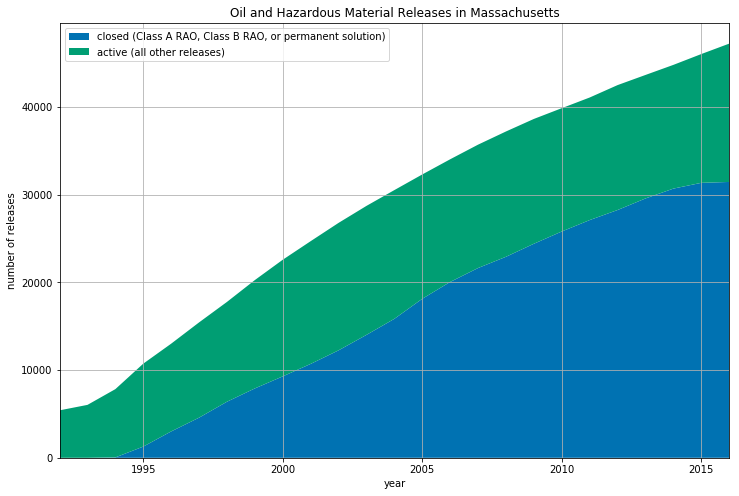

In [7]:
plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize=[12,8])
closed_label = 'closed (Class A RAO, Class B RAO, or permanent solution)'
active_label = 'active (all other releases)'
ax.stackplot(years, [closed_rtn_total, active_rtn_total],
             labels=[closed_label,active_label])
ax.grid()
ax.set_title('Oil and Hazardous Material Releases in Massachusetts')
ax.set_xlabel('year')
ax.set_ylabel('number of releases')
ax.legend(loc='upper left')
ax.set_xlim([1992,2016])
plt.show()

# Conclusions and Suggestions for Further Work
As can be observed in the maps accompanying this study, active cleanup sites were initially clustered around the greater Boston area. As time progressed active cleanup sites became more evenly distributed across the state, but they remained concentrated in certain towns and metropolitan regions. Global Moran’s I analyses for 1991 and 2016 indicate that the clustering observable in the maps has less than a 1 percent chance of being the result of random distribution.

A plot of active and closed hazardous waste cleanup sites is shown above. In contrast to the impression that there are fewer and fewer new hazardous waste sites around to be cleaned up, the plot indicates that the rates of site creation and site closure have largely remained approximately constant and equal over the past 25 years.

For the purposes of this study, the period of active work at a OHM release site wasn't considered to be concluded until a Class A RAO, Class B RAO, or "Permanent Solution" was achieved at the site. It may be the case that many sites enter a state of decreased work well before these official closure conditions are achieved. For example, a site can apply for "down-gradient property status", which assigns liability for environmental cleanup to the owner of an adjacent property where OHM was released and migrated across property boundaries. Future work could look into this possibility.

# References

Canter, L. W., & Sabatini, D. A. (1994). Contamination of public ground water supplies by Superfund sites. International Journal of Environmental Studies, 46(1), 35–57. https://doi.org/10.1080/00207239408710909

Environmental Business International Incorporated. (2016, July 5). U.S. Environmental Contracting Business Grows to $24.5 Billion in Revenues. Retrieved April 4, 2017, from http://www.environmentalbusiness.org/single-post/2016/07/05/US-Environmental-Contracting-Business-Grows-to-245-Billion-in-Revenues

MassDEP. (2017, September). Downloadable Site Lists. Retrieved November 30, 2017, from http://www.mass.gov/eea/agencies/massdep/cleanup/sites/downloadable-site-lists.html

MassGIS. (2017, October 18). MassDEP Tier Classified Oil and/or Hazardous Material Sites (MGL c. 21E). Retrieved November 30, 2017, from https://docs.digital.mass.gov/dataset/massgis-data-massdep-tier-classified-oil-andor-hazardous-material-sites-mgl-c-21e

National Research Council. (2012). Alternatives for Managing the Nation’s Complex Contaminated Groundwater Sites. https://doi.org/10.17226/14668